## Where should I invest my business 

## Imports 

In [1]:
# !pip install scikit-surprise

In [580]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import time
import json
import re
import ast

## data import

In [81]:
business_data = pd.read_json("../data/yelp_academic_dataset_business.json", lines=True) #150k businesses/records 
review_data = pd.read_json("../data/yelp_academic_dataset_review.json", lines=True)

# Restaurants = business_data[business_data['categories'].str.contains('Restaurants', na=False)] #50k records 

# # Filter out closed restaurants
# Restaurants = Restaurants[Restaurants['is_open'] == 1]

# # Filter out restaurants with less than 50 reviews
# Restaurants = Restaurants[Restaurants['review_count'] >= 50]
# # Filter out low-rated restaurants
# Restaurants = Restaurants[Restaurants['business_stars'] >= 1.5]
# print(Restaurants.shape)
# # Merge filtered business data with review data
# Restaurants_merged = pd.merge(Restaurants, review_data, on='business_id', how='inner')
# Restaurants_merged.to_csv('../data/restaurants_w_reviews.csv')

# Restaurants_merged.loc[(Restaurants_merged['latitude'] < -90) | (Restaurants_merged['latitude'] > 90), 'latitude'] = np.nan
# Restaurants_merged.loc[(Restaurants['longitude'] < -180) | (Restaurants_merged['longitude'] > 180), 'longitude'] = np.nan

# # Filter businesses based on industry and location
# industry = 'Restaurants'
# location = 'Philadelphia'
# filtered_business = business_data[(business_data['categories'].str.contains(industry)) & (business_data['city'] == location)]
# # Merge filtered business data with review data
# merged_data = pd.merge(filtered_business, review_data, on='business_id', how='inner')
# # merged_data.to_csv('../data/philly_restaurants.csv')

In [101]:
business_data["business_id"].nunique()

150346

# Filter only Restaurant Data

In [102]:
# create a mask for restaurants
mask_restaurants = business_data['categories'].str.contains('Restaurants')

# create a mask for food
mask_food = business_data['categories'].str.contains('Food')

# apply both masks
restaurants_and_food = business_data[mask_restaurants & mask_food]

# number of businesses that have food and restaurant in their category
restaurants_and_food['categories'].count()

21057

In [103]:
# an example row
restaurants_and_food.head(1)['categories'].values

array(['Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries'],
      dtype=object)

In [107]:
categoryDF = restaurants_and_food['categories'].apply(lambda x: x[0:-1].split(',')).apply(pd.Series)
uniqueCategories = pd.DataFrame(categoryDF.stack().str.strip().unique())

In [113]:
categoriesToRemove = ['Grocery','Drugstores','Convenience Stores','Beauty & Spas','Photography Stores & Services',
                      'Cosmetics & Beauty Supply','Discount Store','Fashion','Department Stores','Gas Stations',
                      'Automotive','Music & Video','Event Planning & Services','Mobile Phones','Health & Medical',
                      'Weight Loss Centers','Home & Garden','Kitchen & Bath','Jewelry',"Children's Clothing",
                      'Accessories','Home Decor','Bus Tours','Auto Glass Services','Auto Detailing',
                      'Oil Change Stations', 'Auto Repair','Body Shops','Car Window Tinting','Car Wash',
                      'Gluten-Free','Fitness & Instruction','Nurseries & Gardening','Wedding Planning',
                      'Embroidery & Crochet','Dance Schools','Performing Arts',
                      'Wholesale Stores','Tobacco Shops','Nutritionists','Hobby Shops','Pet Services',
                      'Electronics','Plumbing','Gyms','Yoga','Walking Tours','Toy Stores','Pet Stores',
                      'Pet Groomers','Vape Shops','Head Shops',
                      'Souvenir Shops','Pharmacy','Appliances & Repair','Wholesalers','Party Equipment Rentals',
                      'Tattoo','Funeral Services & Cemeteries','Sporting Goods','Dog Walkers',
                      'Pet Boarding/Pet Sitting','Scavenger Hunts','Contractors','Trainers', 
                      'Customized Merchandise', 'Dry Cleaning & Laundry', 'Art Galleries'
                      'Tax Law', 'Bankruptcy Law', 'Tax Services', 'Estate Planning Law', 
                      'Business Consulting', 'Lawyers', 'Pet Adoption', 'Escape Games', 
                      'Animal Shelters', 'Commercial Real Estate', 'Real Estate Agents', 
                      'Real Estate Services', 'Home Inspectors']

In [127]:
restaurants_df = restaurants_and_food[~restaurants_and_food['categories'].str.contains('|'.join(categoriesToRemove))]

In [128]:
restaurants_df['business_id'].nunique()

17814

# Create Cusine Feature 

In [133]:
restaurants_df["categories"]

3         Restaurants, Food, Bubble Tea, Coffee & Tea, B...
5         Burgers, Fast Food, Sandwiches, Food, Ice Crea...
9         Ice Cream & Frozen Yogurt, Fast Food, Burgers,...
11               Vietnamese, Food, Restaurants, Food Trucks
14              Food, Delis, Italian, Bakeries, Restaurants
                                ...                        
150306    Restaurants, Specialty Food, Food, Sandwiches,...
150313    Restaurants, Pizza, Fast Food, Chicken Wings, ...
150319    Coffee & Tea, Food, Sandwiches, American (Trad...
150322      Fondue, Beer, Wine & Spirits, Food, Restaurants
150327    Cafes, Juice Bars & Smoothies, Coffee & Tea, R...
Name: categories, Length: 17814, dtype: object

In [135]:
def clean_categories(categories):
    clean_categories = []
    for category in categories:
        split_categories = [cat.strip() for cat in category.split(',')]
        if split_categories[0] in ['Restaurants', 'Food']:
            split_categories = split_categories[1:]
        clean_categories.append(', '.join(split_categories))
    return clean_categories

restaurants_df['categories'] = clean_categories(restaurants_df['categories'])


/var/folders/mc/nc2p69nn6ndg77rgmkqn55yr0000gn/T/ipykernel_84791/199447417.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restaurants_df['categories'] = clean_categories(restaurants_df['categories'])


In [137]:
restaurants_df['categories'].nunique()

10523

In [139]:
restaurants_df['business_id'].nunique() #17814

17814

### Import Restaurant Data 

In [261]:
# restaurants_df.to_csv("../data/restaurants_df.csv")
restaurants_df = pd.read_csv("../data/restaurants_df.csv", index_col=0)


In [262]:
restaurants_df.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Bubble Tea, Coffee & Tea, Bakeries","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Ice Cream & Fr...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '..."


# Turn Categories into columns 

In [171]:
# Split categories by comma
categories = restaurants_df['categories'].str.split(',', expand=True)

# Create dummy variables for each category
dummy_categories = pd.get_dummies(categories, prefix='', prefix_sep='')


# Concatenate the dummy variables with the original dataframe
category_df = pd.concat([restaurants_df, dummy_categories], axis=1)


In [188]:
category_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,Steakhouses,Wine Bars,American (New),Dog Parks,Lounges,Wine & Spirits,Wineries,American (Traditional),Tex-Mex,Salad
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,...,False,False,False,False,False,False,False,False,False,False
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,...,False,False,False,False,False,False,False,False,False,False
9,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,...,False,False,False,False,False,False,False,False,False,False
11,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,NaN,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,...,False,False,False,False,False,False,False,False,False,False
14,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,2575 E Bay Dr,Largo,FL,33771,27.916116,-82.760461,4.5,100,...,False,False,False,False,False,False,False,False,False,False


# Create Cusine Column

In [201]:
business_category = list(category_df.columns)
cusine_list = list(set(business_category))
# Remove whitespace from the beginning of each element
cusine_list = [cuisine.strip() for cuisine in cusine_list]
cusine_list

['Cuban',
 'Armenian',
 'Himalayan/Nepalese',
 'Vitamins & Supplements',
 'Bangladeshi',
 'Fruits & Veggies',
 'Salad',
 'Financial Services',
 'Russian',
 'Sports Bars',
 'Steakhouses',
 'IT Services & Computer Repair',
 'attributes',
 'Shaved Ice',
 'Irish',
 'Food Tours',
 'Hotels & Travel',
 'Sri Lankan',
 'Turkish',
 'Soul Food',
 'Israeli',
 'Landscaping',
 'Tiki Bars',
 'Donuts',
 'Kombucha',
 'Tours',
 'Szechuan',
 'Hainan',
 'Fondue',
 'Polish',
 'Food Court',
 'postal_code',
 'African',
 'Movers',
 'Fast Food',
 'Fast Food',
 'Portuguese',
 'Belgian',
 'Burgers',
 'Food Stands',
 'Public Markets',
 'Tutoring Centers',
 'French',
 'Candy Stores',
 'Shaved Ice',
 'Dinner Theater',
 'Wine & Spirits',
 'Chinese',
 'Popcorn Shops',
 'Falafel',
 'Cafeteria',
 'Local Services',
 'Haitian',
 'Lounges',
 'Venezuelan',
 'Brasseries',
 'Personal Shopping',
 'Waffles',
 'Cheesesteaks',
 'Latin American',
 'Soup',
 'Salvadoran',
 'Eatertainment',
 'Food Banks',
 'Caribbean',
 'Cinema',
 '

In [290]:
cusine_list = ['Cuban',
 'Pizza',
 'Himalayan/Nepalese',
 'Beer',
 'Mediterranean',
 'Bangladeshi',
 'Sardinian',
 'Sicilian',
 'Argentine',
 'Burmese',
 'Austrian',
 'Middle Eastern',
 'Scandinavian',
 'Kosher',
 'Vietnamese',
 'Thai',
 'Persian/Iranian',
 'British',
 'Szechuan',
 'Coffee Roasteries',
 'African',
 'Korean',
 'Ukrainian',
 'Fast Food',
 'Soul Food',
 'Brazilian',
 'Asian Fusion',
 'Comfort Food',
 'Belgian',
 'Arabic',
 'Sushi Bars',
 'French',
 'Coffeeshops',
 'Japanese',
 'Tex-Mex',
 'Calabrian',
 'Noodles',
 'Chinese',
 'Falafel',
 'Halal',
 'Ethiopian',
 'Salad',
 'Ramen',
 'Haitian',
 'Modern European',
 'Iberian',
 'Izakaya',
 'Singaporean',
 'Polish',
 'Salvadoran',
 'Egyptian',
 'Brasseries',
 'Dominican',
 'Italian',
 'Latin American',
 'Indian',
 'Honduran',
 'Peruvian',
 'Tacos',
 'Bakeries',
 'Vegetarian',
 'Vegan',
 'Cambodian',
 'German',
 'Mexican',
 'Hot Pot',
 'Puerto Rican',
 'Irish Pub',
 'Eastern European',
 'Israeli',
 'Health Markets',
 'Sandwiches',
 'Cafes',
 'Malaysian',
 'Laotian',
 'Venezuelan',
 'Barbeque',
 'Armenian',
 'Delis',
 'American (New)',
 'Pakistani',
 'South African',
 'Cantonese',
 'Moroccan',
 'Trinidadian',
 'Burgers',
 'Cajun/Creole',
 'Seafood',
 'Fruits & Veggies',
 'American (Traditional)',
 'Turkish',
 'Colombian',
 'Australian',
 'Patisserie/Cake Shop',
 'Taiwanese',
 'Portuguese',
 'Senegalese',
 'Canadian (New)',
 'Caribbean',
 'Seafood Markets',
 'Afghan',
 'Live/Raw Food',
 'Smokehouse',
 'Greek',
 'Indonesian',
 'Irish',
 'Desserts',
 'Hungarian',
 'Roman',
 'Scottish',
 'Lebanese',
 'Georgian',
 'Syrian',
 'Somali',
 'Tuscan',
 'Breweries',
 'New Mexican Cuisine',
 'Russian',
 'Czech',
 'Southern',
 'Spanish',
 'Dim Sum',
 'Hawaiian',
 'Sri Lankan',
 'Mongolian',
 'Beer Gardens',
 'Chicken Shop',
 'Japanese Curry',
 'Bars', 
 'Diners',
 'Nightlife'
 'Food Stands',
 'Gastropubs',
 'Steakhouses',
 'Wineries',
 'Tapas Bars',
 'Hot Dogs',
 'American (New)',
 'Breakfast & Brunch',
 'Chicken Wings',
 'Local Flavor',
 'Bagels',
 'Food Stands',
 'Farmers Market',
 'American (Traditional)',
 'Ice Cream & Frozen Yogurt',
 'Food Court',
 'Creperies', 
 'Fish & Chips', 
 'Canadian (New)',
 'Food Truck',
 'Buffets', 
 'Ice Cream',
 'Coffee & Tea',
 'Donuts',
 'Guamanian',
 'Bubble Tea',
 'Filipino']

cusine_list = list(set(cusine_list))
cusine_list

['Cuban',
 'Pizza',
 'Himalayan/Nepalese',
 'Mediterranean',
 'Beer',
 'Ice Cream & Frozen Yogurt',
 'Creperies',
 'Bangladeshi',
 'Sardinian',
 'Sicilian',
 'Argentine',
 'Burmese',
 'Austrian',
 'Middle Eastern',
 'Chicken Wings',
 'Scandinavian',
 'Kosher',
 'Vietnamese',
 'Thai',
 'Local Flavor',
 'Persian/Iranian',
 'British',
 'NightlifeFood Stands',
 'Food Stands',
 'Szechuan',
 'Coffee Roasteries',
 'Buffets',
 'Food Court',
 'African',
 'Korean',
 'Ukrainian',
 'Fast Food',
 'Soul Food',
 'Asian Fusion',
 'Brazilian',
 'Comfort Food',
 'Belgian',
 'Arabic',
 'Sushi Bars',
 'French',
 'Coffeeshops',
 'Japanese',
 'Tex-Mex',
 'Calabrian',
 'Noodles',
 'Chinese',
 'Falafel',
 'Halal',
 'Iberian',
 'Ethiopian',
 'Salad',
 'Ramen',
 'Haitian',
 'Modern European',
 'Food Truck',
 'Izakaya',
 'Singaporean',
 'Polish',
 'Salvadoran',
 'Egyptian',
 'Brasseries',
 'Dominican',
 'Italian',
 'Donuts',
 'Latin American',
 'Indian',
 'Farmers Market',
 'Honduran',
 'Peruvian',
 'Tacos',
 'B

In [243]:
#Define a function to extract the cuisine from the "categories" field:
# This function uses regular expressions to search for a match between the 
# cuisines list and the input categories string. It returns the first matched cuisine or 'Other' if no match is found.

""" 
This creates a new column "cuisine" in the DataFrame, 
containing the identified cuisine for each restaurant. 
This approach is computationally efficient, as it avoids using nested loops and takes advantage of pandas' vectorized operations.
"""

def extract_cuisine(categories):
    if not isinstance(categories, str):
        return 'Other'
    
    for cuisine in cusine_list:
        if re.search(r'\b' + cuisine + r'\b', categories, flags=re.IGNORECASE):
            return cuisine
    return 'Other'

In [291]:
restaurants_df['cuisine_type'] = restaurants_df['categories'].apply(extract_cuisine)

In [292]:
restaurants_df['cuisine_type'].value_counts().head(50)

cuisine_type
Fast Food                    4576
Pizza                        1446
Ice Cream & Frozen Yogurt     962
Beer                          956
Bakeries                      893
Sandwiches                    811
Chicken Wings                 769
Cafes                         498
Salad                         482
Donuts                        401
Bars                          379
Soul Food                     347
Comfort Food                  346
Coffee & Tea                  326
Food Stands                   289
Mediterranean                 280
Mexican                       276
Italian                       211
Vietnamese                    190
Seafood                       174
Asian Fusion                  159
Sushi Bars                    148
Barbeque                      133
Burgers                       127
Coffee Roasteries             127
Other                         124
Local Flavor                  123
Chinese                       121
Vegetarian                    119
T

# Merge Reviews 

In [298]:
relevant_business_ids = list(restaurants_df['business_id'])

In [300]:
relevant_review_df = review_data[review_data['business_id'].isin(relevant_business_ids)]

In [306]:
relevant_review_df.to_csv("../data/restaurant_reviews_only.csv", index = False)

In [301]:
relevant_review_df.shape

(1406177, 9)

In [302]:
relevant_review_df.columns

Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date'],
      dtype='object')

In [308]:
# Calculate the average rating and total number of reviews for each restaurant
agg_func = {'stars': ['mean'], 'review_id': ['count']}
restaurant_stats_df = relevant_review_df.groupby('business_id').agg(agg_func)
restaurant_stats_df.columns = ['avg_review_rating', 'total_reviews']

In [309]:
restaurant_stats_df.head()

,avg_review_rating,total_reviews
business_id,,
---kPU91CF4Lq2-WlRu9Lw,4.500000,24
--0iUa4sNDFiZFrAdIWhZQ,3.214286,14
--8IbOsAAxjKRoYsBFL-PA,2.925926,27
--ZVrH2X2QXBFdCilbirsw,4.722222,36
--epgcb7xHGuJ-4PUeSLAw,2.868421,38


In [621]:
# Merge with the relevant business dataframe to add business information
restaurant_w_review = pd.merge(restaurants_df, restaurant_stats_df, on='business_id', how='left')

In [342]:
# restaurant_w_review.to_csv("../data/restaurant_w_review_data.csv")

In [311]:
restaurant_w_review.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,cuisine_type,avg_review_rating,total_reviews
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Bubble Tea, Coffee & Tea, Bakeries","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",Bakeries,4.057471,87
1,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Ice Cream & Fr...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '...",Ice Cream & Frozen Yogurt,2.166667,6
2,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,1,"{'RestaurantsAttire': ""'casual'"", 'Restaurants...","Ice Cream & Frozen Yogurt, Fast Food, Burgers","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '...",Ice Cream & Frozen Yogurt,1.700000,10
3,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,NaN,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,1,"{'Alcohol': ""'none'"", 'OutdoorSeating': 'None'...","Vietnamese, Food Trucks","{'Monday': '11:0-14:0', 'Tuesday': '11:0-14:0'...",Vietnamese,4.090909,11
4,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,2575 E Bay Dr,Largo,FL,33771,27.916116,-82.760461,4.5,100,0,"{'OutdoorSeating': 'False', 'RestaurantsGoodFo...","Delis, Italian, Bakeries","{'Monday': '10:0-18:0', 'Tuesday': '10:0-20:0'...",Italian,4.386792,106


# Possibly remove Closed Restaurants at the statrt of this, 

### Can possibly incorporrate closed restaurants to see what did not work, like the top cusines in the closed restaurants per cty
ex: Most of the closed restaurants in PA, were Italian etc 

In [526]:
restaurant_w_review.shape

(17814, 17)

In [525]:
restaurant_w_review[restaurant_w_review['is_open'] == 0].shape

(4985, 17)

 # Analyze Demand Trends 

### Identifying Top Cusines in Data Set across the board (city and state)

In [485]:
#group the DataFrame by 'city' and 'cuisine', and then calculate the mean of the 'stars' column 
#and the sum of the 'review_count' column for each group.
summary = restaurant_w_review.groupby(['city', 'state','cuisine_type']).agg(
    average_rating=('stars', 'mean'),
    total_reviews=('review_count', 'sum')
).reset_index()

In [487]:
summary.head()

#this says in abington PA there is one restaurant categorized as asian fusion and it has 186 total reviews , and average stas as 3.5 

,city,state,cuisine_type,average_rating,total_reviews
0,Abington,PA,Asian Fusion,3.50,186
1,Abington,PA,Bakeries,4.00,8
2,Abington,PA,Beer,3.50,12
3,Abington,PA,Buffets,3.00,26
4,Abington,PA,Fast Food,1.75,148


 #### There are alot of different types of cusines lets limit it 

In [491]:
"""This line sorts the summary DataFrame by 'city' in ascending order, 
then by 'average_rating' in descending order, and finally by 'total_reviews' in descending order. 
The result is a DataFrame with the top-rated and most-reviewed cuisine types listed first for each city.
"""

sorted_summary = summary.sort_values(by=['city', 'state', 'total_reviews','average_rating',], ascending=[True, True, False, False]).reset_index(drop=True)


In [ ]:
# sorted_summary.drop_duplicates(subset = 'city', keep = 'first', inplace= True)
# sorted_summary.head(50)

In [492]:
#this groups the 
sorted_summary.head()

,city,state,cuisine_type,average_rating,total_reviews
0,Abington,PA,Asian Fusion,3.500000,186
1,Abington,PA,Fast Food,1.750000,148
2,Abington,PA,Sandwiches,3.833333,86
3,Abington,PA,Ice Cream & Frozen Yogurt,3.500000,70
4,Abington,PA,Buffets,3.000000,26


In [490]:
sorted_summary[sorted_summary["cuisine_type"] =='African'].head(20)

,city,state,cuisine_type,average_rating,total_reviews
35,Ambler,PA,African,4.500,86
333,Boise,ID,African,4.500,11
526,Camden,NJ,African,4.000,38
1099,Edmonton,AB,African,3.500,34
1335,Franklin,TN,African,3.500,46
1679,Hendersonville,TN,African,2.500,69
1842,Indianapolis,IN,African,4.000,101
2663,Nashville,TN,African,5.000,192
2700,New Castle,DE,African,4.500,10
2749,New Orleans,LA,African,4.625,596


In [352]:
#Calculate the total number of restaurants for each cuisine type across all cities; meaning 15 african restaurants were reviewed across all ciities, making this category not as populous acoss our sample size 
cuisine_counts = sorted_summary.groupby('cuisine_type')['total_reviews'].count().reset_index()

In [454]:
#Select the top 50 most common cuisine types based on the number of restaurants. Takes cuasine counts which is a df where it tells us how many 
#times a certain kind of restaurant is reviewd, and this code takes the top 10 cusine types that have been reviewed 
top_20_cuisines = cuisine_counts.nlargest(20, 'total_reviews')['cuisine_type']
print(top_20_cuisines.head(10))

42                    Fast Food
81                        Pizza
60    Ice Cream & Frozen Yogurt
7                      Bakeries
88                   Sandwiches
11                         Beer
27                Chicken Wings
39                       Donuts
86                        Salad
22                        Cafes
Name: cuisine_type, dtype: object


In [366]:
#Select the top N cities based on the total number of reviews: The cities with the most reviews 
N = 5  # Set N to your desired number of cities
top_cities = sorted_summary.groupby('city')['total_reviews'].sum().nlargest(N).index

In [367]:
top_cities

Index(['Philadelphia', 'New Orleans', 'Nashville', 'Tampa', 'Indianapolis'], dtype='object', name='city')

In [368]:
#Filter the sorted_summary DataFrame to include only the top 50 cuisines and top N cities:
#gets the top 10 most popular cusines, and the top 5 cities with the most reviews 
filtered_summary = sorted_summary[sorted_summary['cuisine_type'].isin(top_10_cuisines) & sorted_summary['city'].isin(top_cities)]

In [369]:
filtered_summary.head()

,city,cuisine_type,average_rating,total_reviews
1780,Indianapolis,Beer,3.830189,12544
1781,Indianapolis,Fast Food,2.507792,9526
1782,Indianapolis,Sandwiches,3.878788,4920
1783,Indianapolis,Pizza,3.119718,4537
1785,Indianapolis,Salad,3.534483,2924


In [375]:
def create_faceted_barplot(data, values, title):
    g = sns.FacetGrid(data, col='city', col_wrap=4, sharex=False, sharey=False, height=4)
    g.map(sns.barplot, 'cuisine_type', values, order=data['cuisine_type'].unique(), palette='viridis')
    
    for ax in g.axes.flat:
        ax.tick_params(axis='x', labelrotation=90)
    
    g.set_titles('{col_name}')
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle(title)
    plt.show()


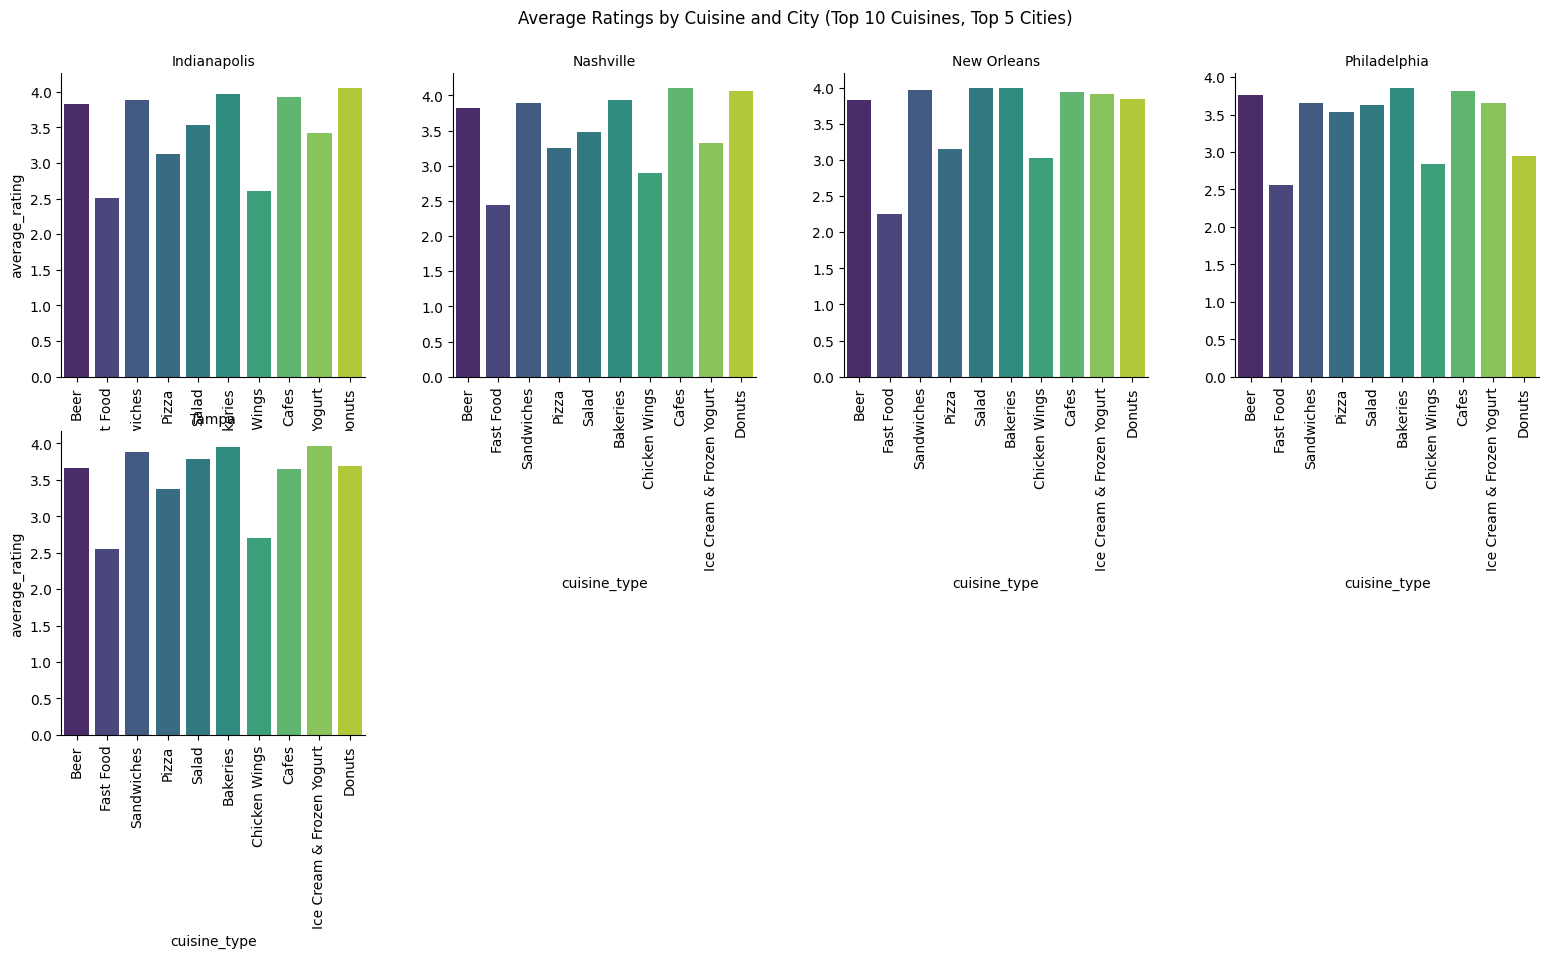

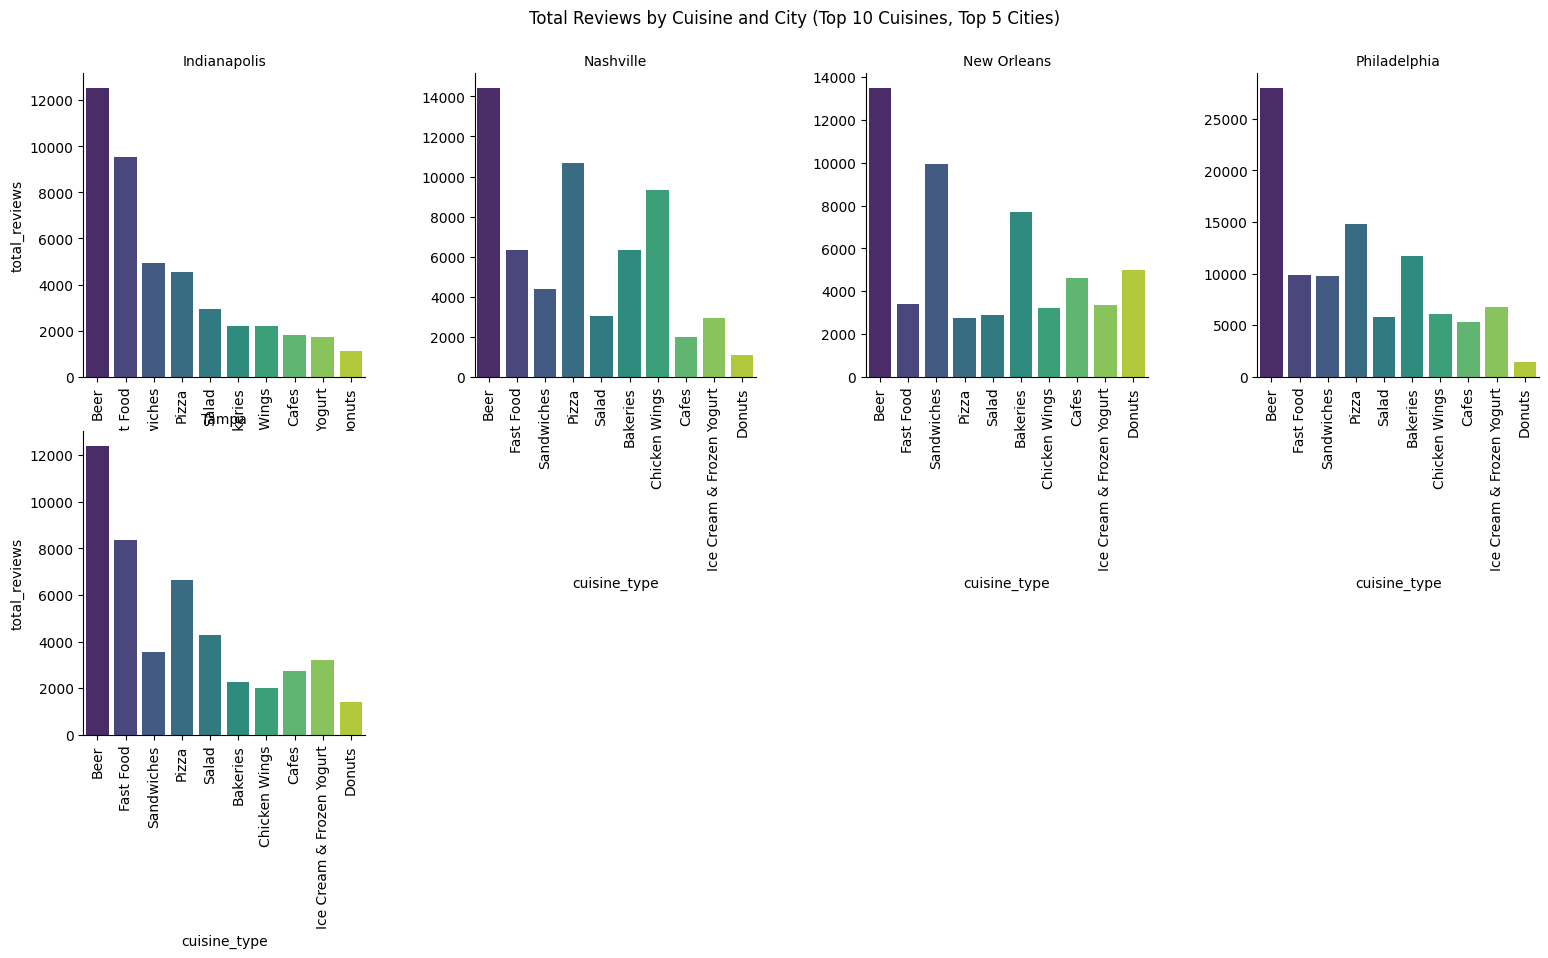

In [376]:
#this plot allows us to see, out of the most reviewed states, what kind of cusines they favor 
create_faceted_barplot(filtered_summary, 'average_rating', 'Average Ratings by Cuisine and City (Top 10 Cuisines, Top {} Cities)'.format(N))
create_faceted_barplot(filtered_summary, 'total_reviews', 'Total Reviews by Cuisine and City (Top 10 Cuisines, Top {} Cities)'.format(N))

# What Cusine Type is Most Popular per State (excluding the majority)

In [493]:
sorted_summary = summary.sort_values(by=['city', 'state', 'total_reviews','average_rating',], ascending=[True, True, False, False]).reset_index(drop=True)


In [504]:
sorted_summary.head()

,city,state,cuisine_type,average_rating,total_reviews
0,Abington,PA,Asian Fusion,3.500000,186
1,Abington,PA,Fast Food,1.750000,148
2,Abington,PA,Sandwiches,3.833333,86
3,Abington,PA,Ice Cream & Frozen Yogurt,3.500000,70
4,Abington,PA,Buffets,3.000000,26


In [505]:
state_cuisine_summary = sorted_summary.groupby(['state', 'cuisine_type']).agg({'average_rating': 'mean', 'total_reviews': 'sum'}).reset_index()
state_cuisine_summary['normalized_rating'] = state_cuisine_summary['average_rating'] / state_cuisine_summary['average_rating'].max()
state_cuisine_summary['normalized_reviews'] = state_cuisine_summary['total_reviews'] / state_cuisine_summary['total_reviews'].max()


In [506]:
state_cuisine_summary.head()

,state,cuisine_type,average_rating,total_reviews,normalized_rating,normalized_reviews
0,AB,African,3.500000,34,0.700000,0.000939
1,AB,Asian Fusion,3.545455,335,0.709091,0.009252
2,AB,Bagels,3.500000,135,0.700000,0.003728
3,AB,Bakeries,3.784091,904,0.756818,0.024965
4,AB,Barbeque,3.833333,33,0.766667,0.000911


In [430]:
rating_weight = 0.5 # Adjust the weight for average_rating as needed
reviews_weight = 0.3  # Adjust the weight for total_reviews as needed

state_cuisine_summary['weighted_score'] = (state_cuisine_summary['normalized_rating'] * rating_weight) + (state_cuisine_summary['normalized_reviews'] * reviews_weight)


In [431]:
state_cuisine_summary.head(10)

,state,cuisine_type,average_rating,total_reviews,normalized_rating,normalized_reviews,weighted_score
0,AB,African,3.500000,34,0.700000,0.000939,0.350282
1,AB,Asian Fusion,3.545455,335,0.709091,0.009252,0.357321
2,AB,Bagels,3.500000,135,0.700000,0.003728,0.351118
3,AB,Bakeries,3.784091,904,0.756818,0.024965,0.385899
4,AB,Barbeque,3.833333,33,0.766667,0.000911,0.383607
5,AB,Bars,3.547059,956,0.709412,0.026402,0.362626
6,AB,Beer,3.747845,1713,0.749569,0.047307,0.388977
7,AB,Brasseries,5.000000,11,1.000000,0.000304,0.500091
8,AB,Breakfast & Brunch,3.500000,8,0.700000,0.000221,0.350066
9,AB,Breweries,3.500000,49,0.700000,0.001353,0.350406


In [432]:
top_cuisines = state_cuisine_summary.loc[state_cuisine_summary.groupby('state')['weighted_score'].idxmax()]


In [433]:
top_cuisines.head(17)

,state,cuisine_type,average_rating,total_reviews,normalized_rating,normalized_reviews,weighted_score
7,AB,Brasseries,5.000000,11,1.000000,0.000304,0.500091
114,AZ,Puerto Rican,5.000000,9,1.000000,0.000249,0.500075
160,CA,Hot Dogs,5.000000,7,1.000000,0.000193,0.500058
206,DE,Hawaiian,5.000000,8,1.000000,0.000221,0.500066
237,FL,Beer,3.773951,29206,0.754790,0.806573,0.619367
349,ID,Latin American,5.000000,28,1.000000,0.000773,0.500232
398,IL,Sushi Bars,4.500000,179,0.900000,0.004943,0.451483
407,IN,Beer,3.759779,15308,0.751956,0.422756,0.502805
518,LA,Soul Food,4.265306,8910,0.853061,0.246065,0.500350
532,MO,Bakeries,4.019001,6238,0.803800,0.172273,0.453582


In [390]:
top_rated_cuisines = state_cuisine_summary.loc[state_cuisine_summary.groupby('state')['average_rating'].idxmax()]
top_reviewed_cuisines = state_cuisine_summary.loc[state_cuisine_summary.groupby('state')['total_reviews'].idxmax()]

In [401]:
top_cuisines.head(20)

,state,cuisine_type,average_rating,total_reviews,normalized_rating,normalized_reviews,weighted_score
7,AB,Brasseries,5.000000,11,1.000000,0.000304,0.600122
114,AZ,Puerto Rican,5.000000,9,1.000000,0.000249,0.600099
137,CA,Beer,4.083333,10115,0.816667,0.279343,0.601737
206,DE,Hawaiian,5.000000,8,1.000000,0.000221,0.600088
237,FL,Beer,3.773951,29206,0.754790,0.806573,0.775503
349,ID,Latin American,5.000000,28,1.000000,0.000773,0.600309
398,IL,Sushi Bars,4.500000,179,0.900000,0.004943,0.541977
407,IN,Beer,3.759779,15308,0.751956,0.422756,0.620276
518,LA,Soul Food,4.265306,8910,0.853061,0.246065,0.610263
532,MO,Bakeries,4.019001,6238,0.803800,0.172273,0.551189


In [394]:
#before 
top_reviewed_cuisines.head(20)

,state,cuisine_type,average_rating,total_reviews
27,AB,Fast Food,2.663203,3070
88,AZ,Fast Food,2.776728,12364
137,CA,Beer,4.083333,10115
202,DE,Fast Food,2.332956,1778
237,FL,Beer,3.773951,29206
319,ID,Beer,3.817005,4786
385,IL,Fast Food,2.300606,2894
407,IN,Beer,3.759779,15308
470,LA,Beer,3.628148,15035
557,MO,Fast Food,2.324432,12897


## Popular per state Take 2 

### Introducing Normalization and weights 

The formula used for normalization in this case is a simple min-max normalization. The purpose of normalization is to bring the values of a column to a common scale, usually in the range [0, 1]. This makes it easier to compare different variables that may have different ranges or units

```
state_cuisine_summary['average_rating'] / state_cuisine_summary['average_rating'].max()

```
divides each value in the 'average_rating' column by the maximum value of that column. This scales the values down to a range between 0 and 1. The highest value (the maximum) in the 'average_rating' column becomes 1, and all other values will be a fraction of that.

Min-max normalization is a simple and widely-used normalization technique. It's particularly useful when comparing variables that have different magnitudes but are measured on a similar scale, like average ratings.

However, it's worth noting that this normalization technique is sensitive to outliers, and in some cases, it may be more appropriate to use other normalization techniques like Z-score normalization or log transformations, depending on the data distribution and the specific analysis being performed.

#### Weights 
Normalization and weighting serve different purposes in the analysis.

Normalization is used to bring variables with different scales or ranges to a common scale, allowing for direct comparison. In this case, we normalize 'average_rating' and 'total_reviews' so that they both fall within the range of [0, 1]. This step is essential because it ensures that the two variables can be combined without one dominating the other due to differences in magnitude.

Weighting, on the other hand, is used to control the relative importance of each variable when combining them to create a new metric. In this case, the 'weighted_score' is a combination of 'normalized_rating' and 'normalized_reviews', where the weights (rating_weight and reviews_weight) determine how much importance each variable has in the final score.

By assigning different weights, you can give more or less importance to average_rating or total_reviews in the calculation of the weighted_score. For example, if you believe that average_rating should have more influence on the final score, you can increase the rating_weight and decrease the reviews_weight accordingly. The sum of both weights should always equal 1.

In summary, normalization is used to make the variables directly comparable, while weighting is used to control the relative importance of each variable in the final combined metric (weighted_score).

In [445]:
excluded_categories = [
    "Fast Food", "Pizza", "Ice Cream & Frozen Yogurt", "Bakeries", "Sandwiches", "Beer", 
    "Chicken Wings", "Donuts", "Salad", "Cafes", "Bars"
]

In [446]:
#Filter the sorted_summary DataFrame to exclude the most popular reviewed categories:
filtered_summary = sorted_summary[~sorted_summary['cuisine_type'].isin(excluded_categories)]

In [447]:
#Group the filtered data by state and cuisine, and calculate the average rating and total reviews for each group:
state_cuisine_summary = filtered_summary.groupby(['state', 'cuisine_type']).agg({'average_rating': 'mean', 'total_reviews': 'sum'}).reset_index()

In [569]:
# Normalize the average_rating and total_reviews columns:
#old
# state_cuisine_summary['normalized_rating'] = state_cuisine_summary['average_rating'] / state_cuisine_summary['average_rating'].max()
# state_cuisine_summary['normalized_reviews'] = state_cuisine_summary['total_reviews'] / state_cuisine_summary['total_reviews'].max()

#new 
mean_rating = state_cuisine_summary['average_rating'].mean()
std_rating = state_cuisine_summary['average_rating'].std()

mean_reviews = state_cuisine_summary['total_reviews'].mean()
std_reviews = state_cuisine_summary['total_reviews'].std()

state_cuisine_summary['zscore_rating'] = (state_cuisine_summary['average_rating'] - mean_rating) / std_rating
state_cuisine_summary['zscore_reviews'] = (state_cuisine_summary['total_reviews'] - mean_reviews) / std_reviews


In [571]:
#Assign weights to average_rating and total_reviews, and calculate the weighted score:
rating_weight = 0.4  # Adjust the weight for average_rating as needed
reviews_weight = 0.6  # Adjust the weight for total_reviews as needed

state_cuisine_summary['weighted_score'] = (state_cuisine_summary['zscore_rating'] * rating_weight) + (state_cuisine_summary['zscore_reviews'] * reviews_weight)


In [572]:
top_cuisines = state_cuisine_summary.loc[state_cuisine_summary.groupby('state')['weighted_score'].idxmax()]
top_cuisines.head(18)

,state,cuisine_type,average_rating,total_reviews,restaurant_count,normalized_reviews,normalized_restaurant_count,market_gap_score,zscore_rating,zscore_reviews,weighted_score
57,AB,Brasseries,5.000000,11,1,0.000935,0.011236,-0.010301,2.256029,-0.540155,0.578319
67,AZ,Comfort Food,3.730769,4877,13,0.414605,0.146067,0.268538,-0.358444,2.955213,1.629750
137,CA,Mediterranean,4.250000,2392,8,0.203349,0.089888,0.113462,0.711113,1.170176,0.986551
227,DE,Hawaiian,5.000000,8,1,0.000680,0.011236,-0.010556,2.256029,-0.542310,0.577026
237,FL,Cuban,4.014085,7913,71,0.672703,0.797753,-0.125050,0.225154,5.136047,3.171690
359,ID,Latin American,5.000000,28,3,0.002380,0.033708,-0.031328,2.256029,-0.527943,0.585646
379,IL,Sushi Bars,4.500000,179,1,0.015217,0.011236,0.003981,1.226085,-0.419476,0.238749
411,IN,Latin American,4.500000,2668,6,0.226813,0.067416,0.159397,1.226085,1.368434,1.311495
463,LA,Comfort Food,3.932432,11763,37,1.000000,0.415730,0.584270,0.056960,7.901597,4.763742
537,MO,Soul Food,3.803030,3868,33,0.328828,0.370787,-0.041959,-0.209594,2.230424,1.254417


In [573]:
import seaborn as sns
import matplotlib.pyplot as plt

def create_barplot(data, y_col, title, xlabel, ylabel, figsize=(15, 10)):
    plt.figure(figsize=figsize)
    sns.barplot(data=data, x='state', y=y_col, hue='cuisine_type', dodge=False, palette='tab10')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(title='Cuisine', loc='upper right')
    plt.xticks(rotation=90)
    plt.show()

## Finalized Top Cusines Per State 

This approach creates a bar plot showing the top cuisine types in each state, considering both average ratings and total reviews based on the weighted score, while excluding the most popular reviewed categories.

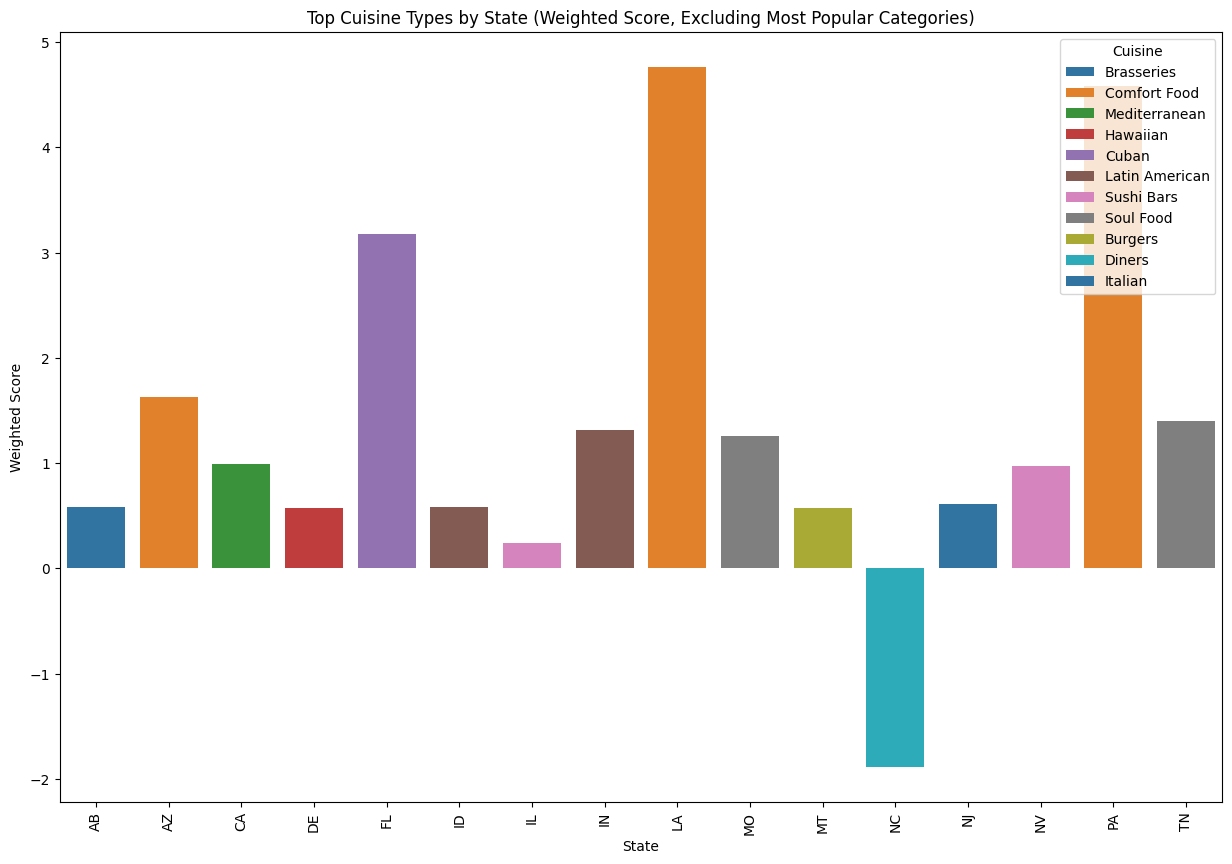

In [574]:
create_barplot(top_cuisines, 'weighted_score', 'Top Cuisine Types by State (Weighted Score, Excluding Most Popular Categories)', 'State', 'Weighted Score')


# Identify Gaps in the Market 

The logic behind calculating the market gap score as the difference between normalized_reviews and normalized_restaurant_count is as follows:

normalized_reviews represents the relative demand for a specific cuisine type in a city or state. A higher value indicates higher demand.
normalized_restaurant_count represents the relative supply (number of restaurants offering that cuisine) in the city or state. A higher value indicates more supply.
By subtracting the normalized_restaurant_count from normalized_reviews, we get the market gap score, which represents the difference between demand and supply.

A positive market gap score indicates that demand is higher than supply, suggesting a potential market gap or opportunity for new businesses in that cuisine type. Conversely, a negative market gap score indicates that supply is higher than demand, implying that the market is saturated for that cuisine type.

In [533]:
summary = restaurant_w_review.groupby(['state','cuisine_type']).agg(
    average_rating=('stars', 'mean'),
    total_reviews=('review_count', 'sum'),
    unique_businesses=('business_id', 'nunique')
).reset_index()

In [535]:
#sorting the values so highest average rating is first
sorted_summary = summary.sort_values(by=['state', 'total_reviews', 'average_rating'], ascending=[True, False, False]).reset_index(drop=True)
sorted_summary.head()

#total _reviews represents the total number of reviews grouped by cusiine. so for asain fusion in Abington PA, the total reviews for resaturants in this category are 
#186 and the restaurants have an average rating of 3.5, and there is exactly 1 unique business

,state,cuisine_type,average_rating,total_reviews,unique_businesses
0,AB,Fast Food,2.937500,3070,224
1,AB,Pizza,3.329897,1962,97
2,AB,Beer,3.728571,1713,35
3,AB,Comfort Food,3.211538,1704,26
4,AB,Cafes,3.950000,1011,40


In [540]:
state_cuisine_summary = sorted_summary[~sorted_summary['cuisine_type'].isin(excluded_categories)]
state_cuisine_summary = state_cuisine_summary.rename(columns={'unique_businesses': 'restaurant_count'})
state_cuisine_summary.head()

,state,cuisine_type,average_rating,total_reviews,restaurant_count
3,AB,Comfort Food,3.211538,1704,26
8,AB,Indian,3.700000,620,15
10,AB,Chinese,3.525000,500,20
11,AB,French,4.500000,486,1
13,AB,Mediterranean,3.800000,338,20


In [541]:
# Normalize the total_reviews and restaurant_count columns:
state_cuisine_summary['normalized_reviews'] = state_cuisine_summary['total_reviews'] / state_cuisine_summary['total_reviews'].max()
state_cuisine_summary['normalized_restaurant_count'] = state_cuisine_summary['restaurant_count'] / state_cuisine_summary['restaurant_count'].max()

In [542]:
# Calculate the market gap score by finding the difference between normalized_reviews and normalized_restaurant_count:
state_cuisine_summary['market_gap_score'] = state_cuisine_summary['normalized_reviews'] - state_cuisine_summary['normalized_restaurant_count']

#Sort the data by market_gap_score in descending order:
sorted_gap_score = state_cuisine_summary.sort_values(by='market_gap_score', ascending=False)


In [561]:
#Select the top N rows with the highest market_gap_score to identify potential market gaps:
N = 15
top_market_gaps = sorted_gap_score.head(N)

In [562]:
top_market_gaps

,state,cuisine_type,average_rating,total_reviews,restaurant_count,normalized_reviews,normalized_restaurant_count,market_gap_score
464,LA,Cajun/Creole,3.547619,10923,21,0.928590,0.235955,0.692635
726,PA,Local Flavor,3.631579,9433,19,0.801921,0.213483,0.588438
463,LA,Comfort Food,3.932432,11763,37,1.000000,0.415730,0.584270
67,AZ,Comfort Food,3.730769,4877,13,0.414605,0.146067,0.268538
730,PA,Middle Eastern,4.043478,5965,23,0.507099,0.258427,0.248672
732,PA,Desserts,4.000000,5220,18,0.443764,0.202247,0.241517
723,PA,Comfort Food,3.938462,11338,65,0.963870,0.730337,0.233533
824,TN,Southern,3.714286,3651,7,0.310380,0.078652,0.231728
481,LA,Breakfast & Brunch,3.750000,2677,2,0.227578,0.022472,0.205106
480,LA,Vegetarian,4.285714,3302,7,0.280711,0.078652,0.202059


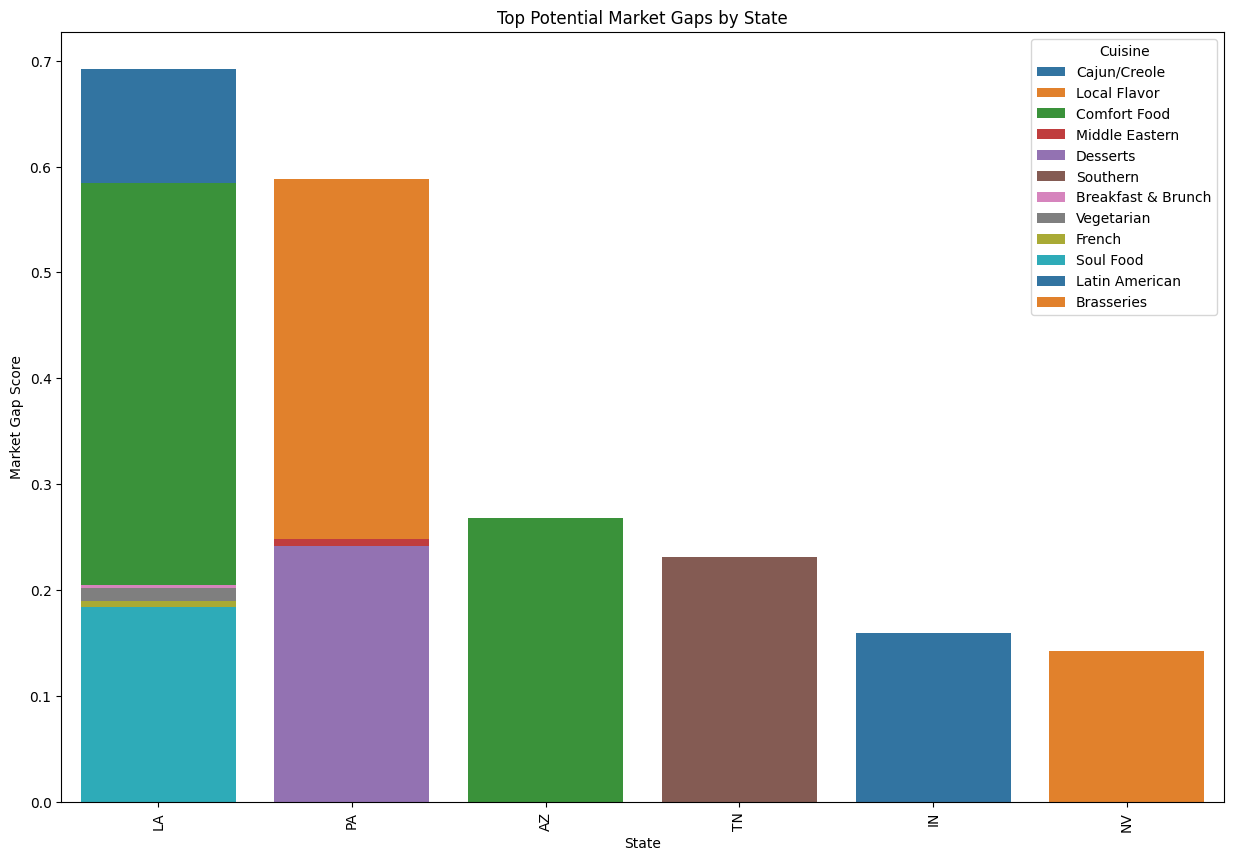

In [563]:
def create_gap_barplot(data, y_col, title, xlabel, ylabel, figsize=(15, 10)):
    plt.figure(figsize=figsize)
    sns.barplot(data=data, x='state', y=y_col, hue='cuisine_type', dodge=False, palette='tab10')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(title='Cuisine', loc='upper right')
    plt.xticks(rotation=90)
    plt.show()

create_gap_barplot(top_market_gaps, 'market_gap_score', 'Top Potential Market Gaps by State', 'State', 'Market Gap Score')


# Analyzing what Business Attrbutes Attract More customers  

In [622]:
#You can use the ast.literal_eval() function to convert the string representation of dictionaries into actual dictionaries (before it wasnt, just nested strings )
def convert_to_dict(x):
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        return {}

restaurant_w_review['attributes'] = restaurant_w_review['attributes'].apply(convert_to_dict)


In [623]:
restaurant_w_review['attributes'].iloc[2]

{'RestaurantsAttire': "'casual'",
 'RestaurantsGoodForGroups': 'False',
 'BusinessAcceptsCreditCards': 'True',
 'OutdoorSeating': 'True',
 'GoodForKids': 'True',
 'Alcohol': "u'none'",
 'BusinessParking': "{'garage': False, 'street': False, 'validated': False, 'lot': False, 'valet': False}",
 'DogsAllowed': 'False',
 'RestaurantsTableService': 'False',
 'ByAppointmentOnly': 'False',
 'WiFi': "u'no'",
 'RestaurantsPriceRange2': '1',
 'RestaurantsReservations': 'False',
 'HasTV': 'True',
 'RestaurantsDelivery': 'True',
 'CoatCheck': 'False',
 'Caters': 'False',
 'RestaurantsTakeOut': 'True',
 'DriveThru': 'True',
 'HappyHour': 'False',
 'WheelchairAccessible': 'True'}

In [625]:
#extract the relevant attributes from the "attributes" column and create new columns for each attribute
# List of relevant attributes
attributes_list = ['RestaurantsDelivery', 'OutdoorSeating', 'BusinessAcceptsCreditCards', 'BusinessParking', 'BikeParking', 'RestaurantsPriceRange2', 'RestaurantsTakeOut', 'ByAppointmentOnly', 'WiFi', 'Alcohol', 'Caters']

# Extract the attributes and create new columns
for attr in attributes_list:
    restaurant_w_review[attr] = restaurant_w_review['attributes'].apply(lambda x: x.get(attr, None))

In [626]:
restaurant_w_review.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,OutdoorSeating,BusinessAcceptsCreditCards,BusinessParking,BikeParking,RestaurantsPriceRange2,RestaurantsTakeOut,ByAppointmentOnly,WiFi,Alcohol,Caters
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,...,False,False,"{'garage': False, 'street': True, 'validated':...",True,1,True,False,u'free',u'none',True
1,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,...,True,True,None,False,1,True,False,u'no',u'none',False
2,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,...,True,True,"{'garage': False, 'street': False, 'validated'...",None,1,True,False,u'no',u'none',False
3,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,NaN,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,...,None,None,"{'garage': False, 'street': False, 'validated'...",None,None,None,None,None,'none',None
4,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,2575 E Bay Dr,Largo,FL,33771,27.916116,-82.760461,4.5,100,...,False,True,"{'garage': False, 'street': False, 'validated'...",True,1,True,None,u'no',u'none',True


In [627]:
# Define a function to convert the nested dictionaries into separate columns
def extract_parking_info(parking_info):
    if parking_info is not None and not pd.isna(parking_info):
        parking_info_dict = ast.literal_eval(parking_info)
        return pd.Series(parking_info_dict)
    else:
        return pd.Series()

# Apply the function to extract the nested information in the BusinessParking column
parking_info_df = restaurant_w_review['BusinessParking'].apply(extract_parking_info)

# Concatenate the extracted parking information to the main business DataFrame
restaurant_w_review = pd.concat([restaurant_w_review, parking_info_df], axis=1)
restaurant_w_review.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,RestaurantsTakeOut,ByAppointmentOnly,WiFi,Alcohol,Caters,garage,street,validated,lot,valet
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,...,True,False,u'free',u'none',True,False,True,False,False,False
1,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,...,True,False,u'no',u'none',False,NaN,NaN,NaN,NaN,NaN
2,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,...,True,False,u'no',u'none',False,False,False,False,False,False
3,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,NaN,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,...,None,None,None,'none',None,False,False,False,False,False
4,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,2575 E Bay Dr,Largo,FL,33771,27.916116,-82.760461,4.5,100,...,True,None,u'no',u'none',True,False,False,False,True,False


In [629]:
import numpy as np

# A custom function to clean the attribute values
def clean_attribute_value(value):
    if value is None:
        return np.nan
    if isinstance(value, str):
        value = value.strip("u'")
        if value.lower() == 'none':
            return np.nan
    return value

# Apply the custom function to clean the attribute values
for attr in attributes_list:
    restaurant_w_review[attr] = restaurant_w_review[attr].apply(clean_attribute_value)

restaurant_w_review.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,RestaurantsTakeOut,ByAppointmentOnly,WiFi,Alcohol,Caters,garage,street,validated,lot,valet
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,...,True,False,free,NaN,True,False,True,False,False,False
1,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,...,True,False,no,NaN,False,NaN,NaN,NaN,NaN,NaN
2,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,...,True,False,no,NaN,False,False,False,False,False,False
3,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,NaN,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,...,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False
4,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,2575 E Bay Dr,Largo,FL,33771,27.916116,-82.760461,4.5,100,...,True,NaN,no,NaN,True,False,False,False,True,False


In [633]:
restaurant_w_review.to_csv("../data/final_restaurant_data.csv")

## How does demand change based on attrbutes 

In [631]:
attributes_list = ['RestaurantsDelivery', 'OutdoorSeating', 
                   'BusinessAcceptsCreditCards', 'BusinessParking', 
                   'BikeParking', 'RestaurantsPriceRange2', 'RestaurantsTakeOut',
                     'ByAppointmentOnly', 'WiFi', 'Alcohol', 'Caters',
                     'garage', 'street', 'validated', 'lot', 'valet']
# Initialize an empty DataFrame to store the results
attribute_percentage_difference = pd.DataFrame()

# Loop through each attribute and calculate the percentage difference in demand and rating
for attr in attributes_list:
    demand_rating = restaurant_w_review.groupby(attr).agg(
        average_demand=('review_count', 'mean'),
        average_rating=('stars', 'mean'),
        count=('business_id', 'count')
    ).reset_index()
    
    # Check if there are at least two levels for the current attribute
    if demand_rating.shape[0] >= 2:
        demand_diff = (demand_rating.loc[1, 'average_demand'] - demand_rating.loc[0, 'average_demand']) / demand_rating.loc[0, 'average_demand'] * 100
        rating_diff = (demand_rating.loc[1, 'average_rating'] - demand_rating.loc[0, 'average_rating']) / demand_rating.loc[0, 'average_rating'] * 100
    else:
        demand_diff = None
        rating_diff = None
    
    # Combine the results in a new DataFrame
    percentage_difference = pd.DataFrame({'attribute': attr, 'demand_difference': demand_diff, 'rating_difference': rating_diff}, index=[0])
    
    # Append the results to the main DataFrame
    attribute_percentage_difference = pd.concat([attribute_percentage_difference, percentage_difference], ignore_index=True)

# Reset the index
attribute_percentage_difference.reset_index(drop=True, inplace=True)


In [632]:
attribute_percentage_difference.head(40)

,attribute,demand_difference,rating_difference
0,RestaurantsDelivery,11.316798,-14.562321
1,OutdoorSeating,114.403912,14.162732
2,BusinessAcceptsCreditCards,9.219100,-16.402971
3,BusinessParking,634.042087,20.787534
4,BikeParking,83.894919,15.146075
5,RestaurantsPriceRange2,225.588679,19.814561
6,RestaurantsTakeOut,75.964154,22.222918
7,ByAppointmentOnly,58.265514,8.339768
8,WiFi,-9.789526,-2.112424
9,Alcohol,34.146852,-5.728974


In [86]:
# # Filter out closed restaurants
# restaurants_df = restaurants_df[restaurants_df['is_open'] == 1]


# SVD First Iteration

Restaurant data (all countries, no filters)

In [64]:
#Prepare the data for the Surprise library
reader = Reader(rating_scale=(1, 5)) #the scale is on for stars is from 1 to 5 ratings based on reviews 
data = Dataset.load_from_df(philly_data[['user_id', 'business_id', 'business_star']], reader)

In [72]:
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=2, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    1.2555  1.2555  1.2555  0.0000  
MAE (testset)     1.0085  1.0083  1.0084  0.0001  
Fit time          44.26   52.66   48.46   4.20    
Test time         315.18  149.01  232.09  83.09   


{'test_rmse': array([1.2554938 , 1.25546506]),
 'test_mae': array([1.00846025, 1.00829222]),
 'fit_time': (44.25664281845093, 52.6581609249115),
 'test_time': (315.1796190738678, 149.0088551044464)}

In [73]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [74]:
def get_recommendations(user_id, n_recommendations=5):
    unique_business_ids = merged_data['business_id'].unique()
    user_recommendations = []

    for business_id in unique_business_ids:
        predicted_rating = svd.predict(user_id, business_id).est
        user_recommendations.append((business_id, predicted_rating))

    user_recommendations.sort(key=lambda x: x[1], reverse=True)

    return user_recommendations[:n_recommendations]

### Get recommendations for a specific user:

In [75]:
Restaurants_merged['user_id'].head()

0    6_SpY41LIHZuIaiDs5FMKA
1    tCXElwhzekJEH6QJe3xs7Q
2    WqfKtI-aGMmvbA9pPUxNQQ
3    3-1va0IQfK-9tUMzfHWfTA
4    EouCKoDfzaVG0klEgdDvCQ
Name: user_id, dtype: object

In [77]:
Restaurants_merged[Restaurants_merged["user_id"] == 'tCXElwhzekJEH6QJe3xs7Q']

,business_id,name,address,city,state,postal_code,latitude,longitude,stars_x,review_count,...,categories,hours,review_id,user_id,stars_y,useful,funny,cool,text,date
1,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,...,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",uduvUCvi9w3T2bSGivCfXg,tCXElwhzekJEH6QJe3xs7Q,4,3,1,2,This is the bakery I usually go to in Chinatow...,2013-10-05 15:19:06
48136,U30ggGzFpXvc2NZYwOW3qg,Mood Cafe,4618 Baltimore Ave,Philadelphia,PA,19143,39.948664,-75.215832,4.5,458,...,"Cafes, Pakistani, Juice Bars & Smoothies, Rest...","{'Monday': '12:0-22:0', 'Tuesday': '12:0-22:0'...",A_bI7RhoLWSduZsfanIcSQ,tCXElwhzekJEH6QJe3xs7Q,5,12,4,5,"Average Yelp rating of 5 stars, after 112 revi...",2013-10-06 17:31:57
316599,Z5po0aTuzKKblek5y6Sp8Q,500 Degrees,1504 Sansom St,Philadelphia,PA,19102,39.950363,-75.166225,3.5,443,...,"Food, Burgers, Restaurants","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",4TvLAMdonTMw4g5FB6bAMg,tCXElwhzekJEH6QJe3xs7Q,4,2,1,1,Back in Philly! Didn't get a chance to try th...,2011-10-02 02:26:47
349396,EtKSTHV5Qx_Q7Aur9o4kQQ,Village Whiskey,118 S 20th St,Philadelphia,PA,19103,39.951417,-75.173768,4.0,1553,...,"Bars, Nightlife, Whiskey Bars, Burgers, Restau...","{'Wednesday': '16:0-21:0', 'Thursday': '16:0-2...",TaTfCqpTwV5vz4Ov5imgbA,tCXElwhzekJEH6QJe3xs7Q,5,1,0,1,....the best burger I've had in my life. Just...,2011-06-02 01:56:45
462638,IH_ZeeTh13jQURbh31d1Kw,Bui's,38th St & Spruce St,Philadelphia,PA,19195,39.951290,-75.199277,4.5,104,...,"Restaurants, Vietnamese, Sandwiches, Local Fla...","{'Monday': '7:0-14:0', 'Tuesday': '7:0-14:0', ...",7-_uxgbZQwnspJYoBVxsxA,tCXElwhzekJEH6QJe3xs7Q,4,1,0,0,Food (8.5/10) = After reading several yelp rev...,2011-05-26 04:09:58
539072,YqmClmk7oLcDzPWKHzgA-Q,South Philadelphia Tap Room,"1509 Mifflin St, Newbold",Philadelphia,PA,19145,39.927216,-75.171477,4.0,530,...,"Breakfast & Brunch, Bars, Nightlife, Restauran...","{'Monday': '12:0-2:0', 'Tuesday': '12:0-2:0', ...",a8XmYeQyIp4k0GCQYKh4Tg,tCXElwhzekJEH6QJe3xs7Q,4,5,1,2,Visited this place with my brother for a late ...,2013-10-05 02:42:11
618163,F48wjJ_jjEz59Prh20XhRA,Tyson Bees,,Philadelphia,PA,19104,39.959169,-75.198419,3.5,147,...,"Food Trucks, Mexican, Korean, Food, Restaurant...","{'Monday': '11:0-17:0', 'Tuesday': '11:0-17:0'...",z0E5YUkMOp_BlYflgpxX3w,tCXElwhzekJEH6QJe3xs7Q,3,0,0,0,Food (7.5/10) = Tried the Korean BBQ Short Rib...,2011-05-25 02:54:43
647730,j-qtdD55OLfSqfsWuQTDJg,Parc,227 S 18th St,Philadelphia,PA,19103,39.949172,-75.170727,4.0,2761,...,"Restaurants, French, Wine Bars, Nightlife, Ame...","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",TKibn0cNXgPB0H5gGf_xiA,tCXElwhzekJEH6QJe3xs7Q,4,2,1,1,"Finally visited this restaurant, after walking...",2013-09-08 22:33:37
809499,8j3blTZChklt3j89jxx0fw,Brauhaus Schmitz,718 South St,Philadelphia,PA,19147,39.942306,-75.154698,4.0,764,...,"Nightlife, Bars, Restaurants, German","{'Monday': '16:0-0:0', 'Tuesday': '16:0-0:0', ...",iHlkWQPXzgSk_GZODzBicA,tCXElwhzekJEH6QJe3xs7Q,5,1,1,0,"Food (9.5/10) = Got the ""Schweinshaxe"" (Rotiss...",2011-05-25 03:20:12
900613,Biidj3QszVuVO0Q85g5NPw,Fu-Wah Mini Market,810 S 47th St,Philadelphia,PA,19143,39.948292,-75.217014,4.5,247,...,"Grocery, Food, Convenience Stores, Restaurants...","{'Monday': '9:0-21:0', 'Tuesday': '9:0-21:0', ...",RnPZqMMplLyhOol1gyV29g,tCXElwhzekJEH6QJe3xs7Q,4,2,1,1,Came back for the Vietnamese pork hoagie. Yea...,2011-10-02 02:35:20


In [76]:
user_id = 'tCXElwhzekJEH6QJe3xs7Q'  # Replace with a user_id from the dataset
recommendations = get_recommendations(user_id)
recommended_business_ids = [business_id for business_id, _ in recommendations]
recommended_businesses = business_data[business_data['business_id'].isin(recommended_business_ids)]
print(recommended_businesses)


                   business_id                                         name   
40360   fq1yCVBgBB7s6V-D68NO1g                                Cafe Mi Quang  \
43168   G4y0HxePBgAYi3iJS_tUPQ                       Chickie's Italian Deli   
47207   3eAGbHu2VFz8dVNC_dO5ow  Lorenzo's Cafe Espresso Ristorante Italiano   
56361   Bze5Vj4MmcE0KHGy346xqw                                 Gyro Express   
115554  AaTpjyw-EiODgi3tR4Xr-g                                        Estia   

                       address          city state postal_code   latitude   
40360      3324 Kensington Ave  Philadelphia    PA       19134  39.998429  \
43168          1014 Federal St  Philadelphia    PA       19147  39.934498   
47207       4741 Princeton Ave  Philadelphia    PA       19135  40.027363   
56361   2101 S 3rd St, Floor 1  Philadelphia    PA       19148  39.921826   
115554          1405 Locust St  Philadelphia    PA       19102  39.948392   

        longitude  stars  review_count  is_open   
40360  -75.